In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns
import tensorflow as tf
from bellotti_r_master_thesis.plot_optimisation_results import draw_confidence_intervals
from multiprocessing import Process, Queue
from mllib.model import KerasSurrogate
from bellotti_r_master_thesis.isodar_scan_helper_functions import AdjustedRSquared
from bellotti_r_master_thesis.invertible_network.invertible_neural_network import InvertibleNetworkSurrogate
from scipy.spatial import ConvexHull
from pymoo.factory import get_performance_indicator

#from bellotti_r_master_thesis.ml_helper_functions import RSquaredSeparated, AdjustedRSquaredSeparated

# Load data

In [2]:
dict_qoi = {'Number of Macro Particles':'Number of Macro Particles',
        'RMS Beamsize in x':'rms_x',
        'RMS Beamsize in y':'rms_y',
        'RMS Beamsize in s':'rms_s',
        'Normalized Emittance x':'emit_x',
        'Normalized Emittance y':'emit_y',
        'Normalized Emittance s':'emit_s',
        'Halo in x':'halo_x',
        'Halo in y':'halo_y',
        'Halo in z':'halo_s',
        'Mean Bunch Energy':'energy',
        'energy spread of the beam':'dE'}
objective_labels = {
    'rms_x': r'$\sigma_x$ [mm]',
    'rms_y': r'$\sigma_y$ [mm]',
    'rms_s': r'$\sigma_s$ [mm]',
    'emit_x': r'$\epsilon_x$ [mm mrad]',
    'emit_y': r'$\epsilon_y$ [mm mrad]',
    'emit_s': r'$\epsilon_s$ [mm mrad]',
    'halo_x': r'$h_x$',
    'halo_y': r'$h_y$',
    'halo_s': r'$h_s$',
    'energy': r'$E$ [MeV]',
    'dE': '$\Delta E$ [keV]',
    'particle_losses': '$N_l$ [%]',
}
qoi_columns =['Number of Macro Particles', 'Mean Bunch Energy', 'RMS Beamsize in x',
       'RMS Beamsize in y', 'RMS Beamsize in s', 'Halo in x', 'Halo in y',
       'Halo in z', 'Normalized Emittance x', 'Normalized Emittance y',
       'Normalized Emittance s', 'energy spread of the beam']
N_part_in = 2e4

In [3]:
base_dir ='/data/user/boiger_r/invertible_network_paper_results5000/models_30_11_2020/isodar/optimisation_paper_7'
plot_dir ='/data/user/boiger_r/invertible_network_paper_results5000/models_30_11_2020/isodar/optimisation_paper_7/plots/plots_paper'
if not os.path.exists(plot_dir):
    os.makedirs(plot_dir)
model_dir = '/data/user/boiger_r/invertible_network_paper_results5000/models_30_11_2020/isodar/models'
model_name = 'isodar_forward_model'
custom_objects = {'AdjustedRSquared': AdjustedRSquared}
kwargs = {'custom_objects': custom_objects,'compile': False}
surr = KerasSurrogate.load(model_dir, model_name, model_kwargs=kwargs)
opal_dir = '/data/user/boiger_r/invertible_network_paper_results5000/models_30_11_2020/isodar_optimisation_paper_7/forward_model_validation'


residual_quantiles = pd.read_csv('/data/user/boiger_r/invertible_network_paper_results5000/models_30_11_2020/isodar/forward_model1/plots/model/forward_prediction_residual_quantiles_by_longitudinal_pos.csv',
                                 sep='\t',
                                 index_col=0)
residual_quantiles = residual_quantiles.rename(dict_qoi,axis=1)
residual_quantiles = residual_quantiles.drop(columns='Number of Macro Particles')
residual_quantiles['particle_losses'] = residual_quantiles['particle_losses']/ N_part_in * 100.
original_data_dir = '/data/user/boiger_r/invertible_network_paper_data/data_sonali'
data_qoi = pd.read_hdf(f'{original_data_dir}/samples_5000_short.hdf5',key='qoi')
data_dvar = pd.read_hdf(f'{original_data_dir}/samples_5000_short.hdf5',key='dvar')
data_qoi = data_qoi.rename(dict_qoi,axis = 1)
data_qoi['particle_losses'] = N_part_in - data_qoi['Number of Macro Particles']
data_qoi = data_qoi.drop(columns='Number of Macro Particles')
data_qoi['particle_losses'] = data_qoi['particle_losses']/ N_part_in * 100.
opal_dir = '/data/user/boiger_r/invertible_network_paper_results5000/models_30_11_2020/isodar/optimisation_paper_7/forward_model_validation'


In [4]:
qois_list = [['dE','emit_x']]
constr = False

In [5]:
residual_quantiles['emit_x']=residual_quantiles['emit_x']*1e7
data_qoi['emit_x']=data_qoi['emit_x']*1e7


In [6]:
endpoint = 50
dpi = 500
q=0.9
gen_overview = [1, 2, 3, 4, 5, 10, 15,20, 50, 100, 500,999]

In [7]:
blue = (0.12156862745098039, 0.4666666666666667, 0.7058823529411765)
orange = (1.0, 0.4980392156862745, 0.054901960784313725)

colormaps = [ListedColormap([(0, 0, 0, 0),(*blue, 0.2),(*blue, 0.4),(*blue, 0.6)]),
             ListedColormap([(0, 0, 0, 0),(*orange, 0.2),(*orange, 0.4),(*orange, 0.6)])]

In [8]:
# fig, axes = plt.subplots(2, 2, figsize=figsize);

# styling
axis_label_size = 25
axis_tick_size = 14
line_width = 2.5
annotation_size = 20
subplot_letter_size = 25

xlim = 26.5
ylim = 25.

colors = sns.color_palette()
cols = [
    'RMS Beamsize in x',
    'Normalized Emittance x',
    'energy spread of the beam',
    'Correlation xpx',
    'Mean Bunch Energy'
];

quantiles_to_plot = [0.5, 0.75, 0.9, 0.95]

In [9]:
qoi100opal = pd.read_hdf(f'{opal_dir}/objectives100_fw1.hdf5',key = 'qoi')
qoi100opal  = qoi100opal.rename(dict_qoi,axis=1)
qoi100opal['emit_x']=qoi100opal['emit_x']*1e7
qoi100toopal = pd.read_hdf(f'{opal_dir}/selected_non_dominated100fw1.hdf5',key = 'obj')
qoi100toopal['emit_x']= qoi100toopal['emit_x']*1e7

In [10]:
qoi100opal_iv = pd.read_hdf(f'{opal_dir}/objectives100_iv1.hdf5',key = 'qoi')
qoi100opal_iv  = qoi100opal_iv.rename(dict_qoi,axis=1)
qoi100opal_iv['emit_x']=qoi100opal_iv['emit_x']*1e7

qoi100toopal_iv = pd.read_hdf(f'{opal_dir}/selected_non_dominated100iv1.hdf5',key = 'obj')
qoi100toopal_iv['emit_x']= qoi100toopal_iv['emit_x']*1e7

In [11]:
SEED = 4679903290
generator = np.random.Generator(np.random.PCG64(SEED))
seed = 49857
tf.random.set_seed(seed)
np.random.seed(seed)

In [12]:
prediction_uncertainty_params = pd.read_csv('/data/user/boiger_r/invertible_network_paper_results5000/models_30_11_2020/isodar/forward_model1/plots/model/residual_parameters.tsv',
                                            sep='\t',
                                            index_col=0)
prediction_uncertainty_params = prediction_uncertainty_params.rename(dict_qoi,axis=1)
prediction_uncertainty_params['emit_x']=prediction_uncertainty_params['emit_x']*1e7
labels = ['random', 'invertible']

# Define functions used

In [13]:
def load_data(data_dirs):
    modellabel = []
    all_dvars = []
    all_objectives  =[]
    i = 0
    for data_dir in data_dirs:
        print(data_dir)
        dvars = []
        objectives = []

        head, tail = os.path.split(data_dir)
        head,labeltext = os.path.split(head)
        modellabel.append(labeltext)

        for g in generations:
            dvar = pd.read_hdf(f'{data_dir}/gen_{g}.hdf5', key='dvar')
            obj = pd.read_hdf(f'{data_dir}/gen_{g}.hdf5', key='obj')

            dvar['generation'] = g
            obj['generation'] = g

            dvars.append(dvar)
            objectives.append(obj)

        dvars = pd.concat(dvars, ignore_index=True)
        objectives = pd.concat(objectives, ignore_index=True)
        objectives['emit_x']=objectives['emit_x']*1e7
        if 'particle_losses' in objectives.keys():
            objectives['particle_losses'] = objectives['particle_losses']/N_part_in * 100
        all_dvars.append(dvars)
        all_objectives.append(objectives)
        if i == 0:
            limits = pd.DataFrame(data=[objectives.min()*0.9, objectives.max()*1.1], index=['min', 'max'])
            limits1 = pd.DataFrame(data=[objectives.min()*0.95, objectives.max()*1.04], index=['min', 'max'])
        i += 1
        
    return all_dvars, all_objectives, limits,limits1, modellabel

In [14]:
def plot_nr_sol_hypervol(all_counts,modellabel,combi,plot_dir,dpi,dist_gd_all_fw,   dist_hv_all_fw,dist_gd_all_iv,   dist_hv_all_iv, generation_list_fw, generation_list_iv, endpoint):
    markersize = 7
    fig, axes = plt.subplots(1,2,figsize=(16, 4.5))
    ax = axes[0]
    for i, counts in enumerate(all_counts):
        ax.plot(counts.keys(), counts.values(), '-o', color=sns.color_palette()[i],markersize = markersize)

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    ax.text(x=800,
            y=250,
            s='random',
            color=sns.color_palette()[0],
            fontsize=annotation_size,
            fontweight= 'bold')
    ax.text(x=750,
            y=750,
            s='invertible',
            color=sns.color_palette()[1],
            fontsize=annotation_size,
            fontweight= 'bold')

    ax.set_xlabel('Generation', fontsize=axis_label_size)
    ax.set_ylabel('No. solutions', fontsize=axis_label_size)
    ax.tick_params(labelsize=axis_tick_size)

    
    
    ax = axes[1]

    ax.plot(generation_list_fw, dist_gd_all_fw,'-*',color=sns.color_palette()[0], label = 'GD random',markersize = markersize)
    ax.plot(generation_list_iv, dist_gd_all_iv,'-*',color=sns.color_palette()[1], label = 'GD invertible',markersize = markersize)

    ax.plot(generation_list_fw,dist_hv_all_fw[-1]-dist_hv_all_fw,'-o',color=sns.color_palette()[0], label = 'HV diff random',markersize = markersize)
    ax.plot(generation_list_iv,dist_hv_all_fw[-1]-dist_hv_all_iv,'-o',color=sns.color_palette()[1],label = 'HV diff invertible',markersize = markersize)

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_xlabel('Generation', fontsize=axis_label_size )
    ax.set_ylabel('Performance Indicators', fontsize=axis_label_size)
    ax.tick_params(labelsize=axis_tick_size)
    ax.legend(loc='upper right', frameon=False, fontsize=axis_tick_size)
    ax.set_xlim([0,endpoint])

    
    for i, char in enumerate(['a', 'b',]):
        axes.flatten()[i].set_title(char,
                                    loc='left',
                                    fontdict={
                                        'fontsize': subplot_letter_size,
                                        'fontweight': 'bold',
                                    },
                                    pad=10)
    fig.tight_layout()    

    fig_title = 'nr_sol_hypervol'+combi+str(endpoint)+'.jpg'
    fig.savefig(f'{plot_dir}/{fig_title}', dpi=dpi,bbox_inches='tight')  

In [15]:
def plot_obj_conf_orig(gen_overview,all_objectives,x_col,y_col,modellabel,residual_quantiles,limits,q,colormaps,objective_labels,current_plot_dir, data_qoi, combi):
# plots the 2 objectives on x and y axis and the according confidence intervals for forward and inverse model for all 
# given generations (gen_overview) in an overview plot in one figure and the original data

    x_limits = [limits[x_col][0]*0.995,limits[x_col][1]]
    y_limits = limits[y_col]
    fig, axes = plt.subplots(4, 3, figsize=(16, 16))
    
    configs_folder='/data/user/boiger_r/invertible_network_paper_results5000/models_30_11_2020/isodar/optimisation_paper_7/invertible_model2/configs'
    obj_config = pd.read_hdf(f'{configs_folder}/configs_dE__emit_x.hdf5', key='obj')
    
    for i, gen in enumerate(gen_overview):   
        ax = axes.flatten()[i]
#        ax.plot(data_qoi[x_col],data_qoi[y_col],'.',markersize = 10,color = sns.color_palette()[8], label = 'original data')
        ax.plot(obj_config[x_col],obj_config[y_col]*1e7,'ok',markerfacecolor='none',markersize = 10,label = 'initial')

        for i, objectives in enumerate(all_objectives):
            df = objectives.query('`generation` == @gen')
                
            ax.plot(df[x_col],
                    df[y_col],
                    'o',
                    markersize=10.,
                    color=sns.color_palette()[i],
                    label = modellabel[i])
            draw_confidence_intervals(df[x_col].values,
                                      df[y_col].values,
                                      [q],
                                      [residual_quantiles.loc[q, x_col]],
                                      [residual_quantiles.loc[q, y_col]],
                                      x_limits,
                                      y_limits,
                                      50,
                                      colormaps[i],
                                      ax)


        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)


        ax.set_xlabel(objective_labels[x_col], fontsize=axis_label_size)
        ax.set_ylabel(objective_labels[y_col], fontsize=axis_label_size)
        ax.tick_params(labelsize=axis_tick_size)

        ax.set_xlim(x_limits)
        ax.set_ylim(y_limits)

        ax.text(x=x_limits[0]*1.005,
                y=y_limits[1],
                s=f'Generation {gen}',
                fontsize=annotation_size)
        if gen == 999:
            
            ax.legend(loc='upper right', frameon= False, fontsize=axis_tick_size,handletextpad=0.01)
    fig.tight_layout()
    fig.align_labels()

    
    fig_title = 'generations_conf_orig'+combi+'.jpg'
    fig.savefig(f'{plot_dir}/{fig_title}', dpi=dpi,bbox_inches='tight')

In [16]:
def plot_opal_validation_fw_iv(limits, x_col, y_col,qoi100opal, qoi100opal_iv,data_qoi,qoi_pred, qoi_pred_iv,qoi100toopal,qoi100toopal_iv,q,residual_quantiles,colormaps,objective_labels):

    fig, axes = plt.subplots(1, 2, figsize = (16,9))

    markersize = 10
    ax = axes[0]

    x_limits = limits[x_col]
    y_limits = limits[y_col]

    ax.plot(qoi100opal[x_col],qoi100opal[y_col],'^k', markersize = markersize, label ='OPAL validated points')
    #plt.plot(qoi5opal['dE'],qoi5opal['emit_x'],'+g')
    #plt.plot(qoi5toopal['dE'],qoi5toopal['emit_x'],'+m')
    ax.plot(data_qoi[x_col],data_qoi[y_col],'^', markersize = markersize, color ='#858585', label = 'original OPAL data')
    ax.plot(qoi_pred[x_col],qoi_pred[y_col],'o', markersize =markersize, color = sns.color_palette()[0], label = 'optimal Pareto front')
    ax.plot(qoi100toopal[x_col],qoi100toopal[y_col],'ok', markersize =markersize, label = 'points for validation')

    draw_confidence_intervals(qoi_pred[x_col].values,
                          qoi_pred[y_col].values,
                          [q],
                          [residual_quantiles.loc[q, x_col]],
                          [residual_quantiles.loc[q, y_col]],
                          x_limits,
                          y_limits,
                          50,
                          colormaps[0],
                          ax)

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_xlabel(objective_labels[x_col],fontsize=axis_label_size)
    ax.set_ylabel(objective_labels[y_col], fontsize=axis_label_size)
    ax.tick_params(labelsize=axis_tick_size)
    ax.set_xlim(x_limits)
    ax.set_ylim(y_limits)
    fig.align_labels()
    ax.legend(loc='lower left', frameon=False, fontsize=axis_tick_size,handletextpad=0.01)
    ax.text(x=x_limits[0]*1.01,
            y=y_limits[1]*0.99,
            s='Random',
            color=sns.color_palette()[0],
            fontsize=annotation_size, 
            fontweight = 'bold')
    

    ax = axes[1]
    x_limits = limits[x_col]
    y_limits = limits[y_col]
    #plasma = cm.get_cmap('plasma', 12)


    ax.plot(qoi100opal_iv[x_col],qoi100opal_iv[y_col],'^k', markersize = markersize, label ='OPAL validated points')
    #plt.plot(qoi5opal['dE'],qoi5opal['emit_x'],'+g')
    #plt.plot(qoi5toopal['dE'],qoi5toopal['emit_x'],'+m')
    ax.plot(data_qoi[x_col],data_qoi[y_col],'^',  color ='#858585',markersize = markersize, label = 'original OPAL data')
    ax.plot(qoi_pred_iv[x_col],qoi_pred_iv[y_col],'o', markersize =markersize, color = sns.color_palette()[1], label = 'optimal Pareto front')
    ax.plot(qoi100toopal_iv[x_col],qoi100toopal_iv[y_col],'ok', markersize =markersize, label = 'points for validation')

    draw_confidence_intervals(qoi_pred[x_col].values,
                          qoi_pred[y_col].values,
                          [q],
                          [residual_quantiles.loc[q, x_col]],
                          [residual_quantiles.loc[q, y_col]],
                          x_limits,
                          y_limits,
                          50,
                          colormaps[1],
                          ax)

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_xlabel(objective_labels[x_col], fontsize=axis_label_size)
    ax.set_ylabel(objective_labels[y_col], fontsize=axis_label_size)
    ax.tick_params(labelsize=axis_tick_size)
    ax.set_xlim(x_limits)
    ax.set_ylim(y_limits)
    fig.align_labels()
    ax.legend(loc='lower left', frameon=False, fontsize=axis_tick_size,handletextpad=0.01)
    ax.text(x=x_limits[0]*1.01,
            y=y_limits[1]*0.99,
            s='Invertible',
            color=sns.color_palette()[1],
            fontsize=annotation_size, 
            fontweight = 'bold')
    
    for i, char in enumerate(['a', 'b',]):
        axes.flatten()[i].set_title(char,
                                    loc='left',
                                    fontdict={
                                        'fontsize': subplot_letter_size,
                                        'fontweight': 'bold',
                                    },
                                    pad=10)

    fig.tight_layout()

    #fig.text(x=0.07, y=0.9,s='a',fontsize=20,fontweight='bold')
    #fig.text(x=0.57,y=0.9,s='b', fontsize=20,fontweight='bold')

    fig.savefig(f'{plot_dir}/plot_opal_validation_fw_iv.jpg', dpi=dpi,bbox_inches='tight')

In [17]:
def sample_residuals(generator, params, N):
    '''
    Sample N configurations from the given parameters.
    
    Parameters
    ----------
    generator: numpy.random.Generator
        Used to generate the random numbers.
    params: pd.DataFrame
        Contains the row index values 'mean' and 'std'
        indicating the parameters of the normal distribution
        to sample from.
    N: int
        Number pf samples to generate.
    '''
    df = {}
    
    for col in params.columns:
        df[col] = generator.normal(loc=params.loc['mean', col],
                                   scale=params.loc['std', col],
                                   size=N)
    
    return pd.DataFrame(df)

In [18]:
def sample_volumes(prediction, params, N_tries):
    volumes = []
    for N in range(N_tries):
        residuals = sample_residuals(generator,
                                     params,
                                     prediction.shape[0])
        sampled_configs = prediction + residuals[[x_col,y_col]]
        sampled_configs.clip(lower=0., inplace=True)
        hull = ConvexHull(sampled_configs.values)
        volumes.append(hull.volume)
    return volumes

In [19]:
def plot_optimization_isodar(x_col,y_col,labels,all_objectives,gen_overview1,all_volume_means,all_volume_stds):
    fig, axes = plt.subplots(1, 3, figsize=(16, 4.5))

   # offset = 10

    for i, col in enumerate([x_col,y_col]):
        ax = axes[i]
        print(col)
        for i, label in enumerate(labels):
            values = all_objectives[i]
            minimum = values.groupby('generation').min()[col]
            maximum = values.groupby('generation').max()[col]

            ax.fill_between(x=minimum.index,
                            y1=minimum.values,
                            y2=maximum.values,
                            color=sns.color_palette()[i],
                            alpha=0.3)

      #  ax.set_ylim(limits[col])
        ax.set_xlim([0,100])
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)

        ax.set_xlabel('Generation', fontsize=axis_label_size)
        ax.set_ylabel(objective_labels[col], fontsize=axis_label_size)
        ax.tick_params(labelsize=axis_tick_size)
    ax.text(x=48, y=4.5, s=labels[0], fontsize=annotation_size,fontweight='bold', color=sns.color_palette()[0])
    ax.text(x=40, y=4.545, s=labels[1], fontsize=annotation_size,fontweight='bold', color=sns.color_palette()[1])

    ax = axes[2]
    ax.plot(gen_overview1, all_volume_means[0], color = sns.color_palette()[0],label = labels[0])
    ax.plot(gen_overview1, all_volume_means[1], color = sns.color_palette()[1],label = labels[1])
    ax.fill_between(gen_overview1, all_volume_means[0] - all_volume_stds[0], all_volume_means[0] + all_volume_stds[0], alpha=0.3)
    ax.fill_between(gen_overview1, all_volume_means[1] - all_volume_stds[1], all_volume_means[1] + all_volume_stds[1], alpha=0.3)

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    ax.set_xlabel('Generation', fontsize=axis_label_size)
    ax.set_ylabel('$V_{ch}$', fontsize=axis_label_size)
    ax.tick_params(labelsize=axis_tick_size)

    
    ax_inset = ax.inset_axes([450, 0.0005, 500, 0.0075], transform=ax.transData)

    endp = 25
    line_width = 2.5
    ax_inset.plot(gen_overview1[:endp],
                    all_volume_means[0][:endp],
                    linewidth=line_width, 
                    color = sns.color_palette()[0])

    ax_inset.plot(gen_overview1[:endp],
                    all_volume_means[1][:endp],
                    linewidth=line_width, 
                    color = sns.color_palette()[1])
    ax_inset.fill_between(gen_overview1[:endp],
                          all_volume_means[0][:endp] - all_volume_stds[0][:endp],
                          all_volume_means[0][:endp] + all_volume_stds[0][:endp], alpha=0.3)
    ax_inset.fill_between(gen_overview1[:endp],
                          all_volume_means[1][:endp] - all_volume_stds[1][:endp],
                          all_volume_means[1][:endp] + all_volume_stds[1][:endp], alpha=0.3)


    ax_inset.set_xlim([0, 50])
    ax_inset.set_ylim([0., 0.007])
    #ax_inset.set_xticklabels([])
    ax_inset.spines['top'].set_visible(False)
    ax_inset.spines['right'].set_visible(False)
    ax_inset.tick_params(axis='y', labelsize=10)
    ax_inset.tick_params(axis='x', labelsize=10)

    patch, connector_lines = ax.indicate_inset([0, 0, 50, 0.007], ax_inset)
    #connector_lines[1].set_visible(True)
    #connector_lines[2].set_visible(True)
    #connector_lines[0].set_visible(True)
    #connector_lines[3].set_visible(True)
    #connector_lines[3].xy1 = (1.2, 1.0)


        
    for i, char in enumerate(['a', 'b','c']):
        axes.flatten()[i].set_title(char,
                                    loc='left',
                                    fontdict={
                                        'fontsize': subplot_letter_size,
                                        'fontweight': 'bold',
                                    },
                                    pad=10)
    

    fig.tight_layout()
    fig.savefig(f'{plot_dir}/optimization_isodar.jpg', dpi=dpi,bbox_inches='tight')

In [20]:
def load_gen_data(all_objectives_df, gen ):
    points_gen = all_objectives_df[all_objectives_df['generation']==gen]
    points_gen = points_gen.drop(columns = 'generation')
    return points_gen

In [21]:
def normalize_points_df(df):
    df_col = df.columns
    xmean = df[df_col[0]].mean()
    ymean = df[df_col[1]].mean()
    df[df_col[0]] = df[df_col[0]] / xmean
    df[df_col[1]] = df[df_col[1]] / ymean
    return df, xmean, ymean

In [22]:
def compute_pymoo_dist(all_objectives, generation_list_fw, generation_list_iv,xcol,ycol):
    #https://pymoo.org/misc/performance_indicator.html
    points999_fw = load_gen_data(all_objectives[0],999)
    
    points999_fw, xmean999, ymean999 = normalize_points_df(points999_fw)
    points999_fw = points999_fw.values
    dist_gd_all_fw = []
    dist_hv_all_fw = []
    dist_gd_all_iv = []
    dist_hv_all_iv = []
    gd = get_performance_indicator("gd", points999_fw)
    hv = get_performance_indicator("hv", ref_point=np.array([1.4, 1.4]))
    
    for gen in generation_list_fw:
        test = load_gen_data(all_objectives[0],gen)
        test[xcol] =test[xcol]/xmean999
        test[ycol] =test[ycol]/ymean999
        test = test.values
        dist_gd_all_fw.append(gd.calc(test))
        dist_hv_all_fw.append(hv.calc(test))

    for gen in generation_list_iv:
        test = load_gen_data(all_objectives[1],gen)
        test[xcol] =test[xcol]/xmean999
        test[ycol] =test[ycol]/ymean999
        test = test.values
        dist_gd_all_iv.append(gd.calc(test))
        dist_hv_all_iv.append(hv.calc(test))
        
    return dist_gd_all_fw, dist_hv_all_fw,dist_gd_all_iv, dist_hv_all_iv   

# Define functions unused

In [23]:
def plot_nr_of_solutions(all_counts,modellabel,combi,plot_dir,dpi):
    fig, ax = plt.subplots(figsize=(8, 5))

    for i, counts in enumerate(all_counts):
        ax.plot(counts.keys(), counts.values(), '-o', color=sns.color_palette()[i],markersize = 7)

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    ax.text(x=600,
            y=1000,
            s='random',
            color=sns.color_palette()[0],
            fontsize=annotation_size)
    ax.text(x=200,
            y=5000,
            s='invertible',
            color=sns.color_palette()[1],
            fontsize=annotation_size)

    ax.set_xlabel('Generation', fontsize=axis_label_size)
    ax.set_ylabel('# non-dominated (cumulative)', fontsize=axis_label_size)
    ax.tick_params(labelsize=axis_tick_size)

    fig.tight_layout()
    fig_title = 'number_of_solutions_'+combi+'.jpg'
#    fig.savefig(f'{plot_dir}/{fig_title}', dpi=dpi) 

In [24]:
def plot_opal_validation(limits, x_col, y_col,qoi100opal,data_qoi,qoi_pred,qoi100toopal,q,residual_quantiles,colormaps,objective_labels):
    fig,ax = plt.subplots(figsize=(10,8))
    x_limits = limits[x_col]
    y_limits = limits[y_col]

    ax.plot(qoi100opal[x_col],qoi100opal[y_col],'^k', markersize = 10, label ='opal validated points')
#plt.plot(qoi5opal['dE'],qoi5opal['emit_x'],'+g')
#plt.plot(qoi5toopal['dE'],qoi5toopal['emit_x'],'+m')
    ax.plot(data_qoi[x_col],data_qoi[y_col],'^', markersize = 10, color ='#858585', label = 'original opal data')
    ax.plot(qoi_pred[x_col],qoi_pred[y_col],'o', markersize =10, color = sns.color_palette()[0], label = 'optimal pareto front')
    plt.plot(qoi100toopal[x_col],qoi100toopal[y_col],'ok', markersize =12, label = 'points for validation')

    draw_confidence_intervals(qoi_pred[x_col].values,
                          qoi_pred[y_col].values,
                          [q],
                          [residual_quantiles.loc[q, x_col]],
                          [residual_quantiles.loc[q, y_col]],
                          x_limits,
                          y_limits,
                          50,
                          colormaps[0],
                          ax)

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_xlabel(objective_labels[x_col],fontsize=axis_label_size)
    ax.set_ylabel(objective_labels[y_col], fontsize=axis_label_size)
    ax.tick_params(labelsize=axis_tick_size)
    ax.set_xlim(x_limits)
    ax.set_ylim(y_limits)
    fig.align_labels()
    ax.legend(loc='lower left', frameon=False, fontsize=axis_tick_size)

    fig.tight_layout()

    fig_title = 'objective_space_opal_validation_1.jpg'
    fig.savefig(f'{plot_dir}/{fig_title}', dpi=dpi)

In [25]:
def plot_opal_validation_iv(limits, x_col, y_col,qoi100opal,data_qoi,qoi_pred,qoi100toopal,q,residual_quantiles,colormaps,objective_labels):
    fig,ax = plt.subplots(figsize=(10,8))
    x_limits = limits[x_col]
    y_limits = limits[y_col]
    #plasma = cm.get_cmap('plasma', 12)

    
    ax.plot(qoi100opal[x_col],qoi100opal[y_col],'^k', markersize = 10, label ='opal validated points')
#plt.plot(qoi5opal['dE'],qoi5opal['emit_x'],'+g')
#plt.plot(qoi5toopal['dE'],qoi5toopal['emit_x'],'+m')
    ax.plot(data_qoi[x_col],data_qoi[y_col],'^',  color ='#858585',markersize = 10, label = 'original opal data')
    ax.plot(qoi_pred[x_col],qoi_pred[y_col],'o', markersize =10, color = sns.color_palette()[1], label = 'optimal pareto front')
    plt.plot(qoi100toopal[x_col],qoi100toopal[y_col],'ok', markersize =12, label = 'points for validation')

    draw_confidence_intervals(qoi_pred[x_col].values,
                          qoi_pred[y_col].values,
                          [q],
                          [residual_quantiles.loc[q, x_col]],
                          [residual_quantiles.loc[q, y_col]],
                          x_limits,
                          y_limits,
                          50,
                          colormaps[1],
                          ax)

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_xlabel(objective_labels[x_col], fontsize=axis_label_size)
    ax.set_ylabel(objective_labels[y_col], fontsize=axis_label_size)
    ax.tick_params(labelsize=axis_tick_size)
    ax.set_xlim(x_limits)
    ax.set_ylim(y_limits)
    fig.align_labels()
    ax.legend(loc='lower left', frameon=False, fontsize=axis_tick_size)

    fig.tight_layout()

    fig_title = 'objective_space_opal_validation_iv_1.jpg'
    fig.savefig(f'{plot_dir}/{fig_title}', dpi=dpi)

In [26]:
def plot_volume_convex_hull(gen_overview1,all_volume_means,all_volume_stds,labels):
    fig, ax = plt.subplots(figsize = (8,4.5))
    plt.plot(gen_overview1, all_volume_means[0], color = sns.color_palette()[0],label = labels[0])
    plt.plot(gen_overview1, all_volume_means[1], color = sns.color_palette()[1],label = labels[1])
    ax.fill_between(gen_overview1, all_volume_means[0] - all_volume_stds[0], all_volume_means[0] + all_volume_stds[0], alpha=0.3)
    ax.fill_between(gen_overview1, all_volume_means[1] - all_volume_stds[1], all_volume_means[1] + all_volume_stds[1], alpha=0.3)

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    ax.set_xlabel('Generation', fontsize=25)
    ax.set_ylabel('$V_{ch}$', fontsize=25)
    ax.tick_params(labelsize=14)

    for i, label in enumerate(labels):
        ax.text(x=200,
            y=all_volume_means[i][-30],
            s=label,
            va='center',
            fontsize=20,
            color=sns.color_palette()[i])
#ax.set_xlim([0, 1400])
#ax.set_xticks(ax.get_xticks()[:-2]);

    fig.tight_layout()
    #fig.savefig(f'{plot_dir}/volume_of_convex_hull_obj_space.jpg', dpi=dpi)

In [27]:
def plot_objective_ranges(x_col,y_col,all_objectives,objective_labels,labels):
    fig, axes = plt.subplots(1, 2, figsize=(16, 4.5))

    offset = 10

    for i, col in enumerate([x_col,y_col]):
        ax = axes[i]
        for i, label in enumerate(labels):
            values = all_objectives[i]
            minimum = values.groupby('generation').min()[col]
            maximum = values.groupby('generation').max()[col]

            ax.fill_between(x=minimum.index,
                            y1=minimum.values,
                            y2=maximum.values,
                            color=sns.color_palette()[i],
                            alpha=0.3)

      #  ax.set_ylim(limits[col])
        ax.set_xlim([0,100])
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)

        ax.set_xlabel('Generation', fontsize=42)
        ax.set_ylabel(objective_labels[col], fontsize=42)
        ax.tick_params(labelsize=25)
    fig.text(x=0.2, y=1.1, s=labels[0], fontsize=40, color=sns.color_palette()[0])
    fig.text(x=0.55, y=1.1, s=labels[1], fontsize=40, color=sns.color_palette()[1])

    fig.tight_layout()
    #fig.savefig(f'{plot_dir}/objective_ranges.jpg', dpi=dpi)

In [28]:
def plot_pymoo_dist_paper(dist_gd_all_fw,   dist_hv_all_fw,dist_gd_all_iv,   dist_hv_all_iv, generation_list_fw, generation_list_iv, combi, plot_dir,endpoint):
    fig, ax = plt.subplots(figsize=(8, 5))

    ax.plot(generation_list_fw, dist_gd_all_fw,'-*',color=sns.color_palette()[0], label = 'GD random init',markersize = 10)
    ax.plot(generation_list_iv, dist_gd_all_iv,'-*',color=sns.color_palette()[1], label = 'GD invertible model init',markersize = 10)

    ax.plot(generation_list_fw,dist_hv_all_fw[-1]-dist_hv_all_fw,'-o',color=sns.color_palette()[0], label = 'HV diff random init',markersize = 7)
    ax.plot(generation_list_iv,dist_hv_all_fw[-1]-dist_hv_all_iv,'-o',color=sns.color_palette()[1],label = 'HV diff invertible model init',markersize = 7)

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_xlabel('Generation', fontsize=20 )
    ax.set_ylabel('Performance Indicators', fontsize=20)
    ax.tick_params(labelsize=16)
    ax.legend(loc='upper right', shadow=True, fontsize=16)
    ax.set_xlim([0,endpoint])
    
    fig.tight_layout()
    

    fig_title = 'hypervolume_diff_gen_dist'+combi+str(endpoint)+'.jpg'
#    fig.savefig(f'{plot_dir}/{fig_title}', dpi=dpi)  


# Plot functions

In [29]:
configs_folder='/data/user/boiger_r/invertible_network_paper_results5000/models_30_11_2020/isodar/optimisation_paper_7/invertible_model2/configs'
obj_config = pd.read_hdf(f'{configs_folder}/configs_dE__emit_x.hdf5', key='obj')
obj_config['emit_x']= obj_config['emit_x']*1e7

In [30]:
import sklearn
sklearn.__version__

'0.23.2'

In [31]:
all_qois = ['Number of Macro Particles', 'energy', 'rms_x', 'rms_y', 'rms_s',
       'halo_x', 'halo_y', 'halo_s', 'emit_x', 'emit_y', 'emit_s', 'dE']

out_dir = '/data/user/boiger_r/invertible_network_paper_results5000/models_30_11_2020/isodar/optimisation_paper_7'
qois = ["dE","emit_x"]
qois_folder = str(qois[0])+'__'+str(qois[1])

out_dir_fw = f'{out_dir}/forward_model/{qois_folder}'
val_surr = KerasSurrogate.load(model_dir, 'isodar_forward_model', model_kwargs=kwargs)
surr_iv = InvertibleNetworkSurrogate.load(model_dir, 'isodar_invertible_model2', model_kwargs=kwargs)

dvar999 = pd.read_hdf(f'{out_dir_fw}/gen_{999}.hdf5', key='dvar')
qoi999_pred = val_surr.predict(dvar999)
target_vector = qoi999_pred[7]  #50


In [32]:
target_part_loss = 2e4 - target_vector[0]
target_part_loss

7090.034276804465

In [33]:
qoi999_pred_df = pd.DataFrame(qoi999_pred,columns = all_qois)
print(qoi999_pred_df.loc[7])
target_vector[8]=target_vector[8]*1e7

Number of Macro Particles    1.290997e+04
energy                       1.119747e+02
rms_x                        2.363913e-03
rms_y                        2.115782e-03
rms_s                        1.492572e-03
halo_x                       4.521164e+00
halo_y                       3.629567e+00
halo_s                       3.439164e+00
emit_x                       4.173047e-07
emit_y                       4.501123e-07
emit_s                       2.075776e-07
dE                           1.461548e-01
Name: 7, dtype: float64


/data/user/boiger_r/invertible_network_paper_results5000/models_30_11_2020/isodar/optimisation_paper_7/forward_model/dE__emit_x
/data/user/boiger_r/invertible_network_paper_results5000/models_30_11_2020/isodar/optimisation_paper_7/invertible_model2/dE__emit_x


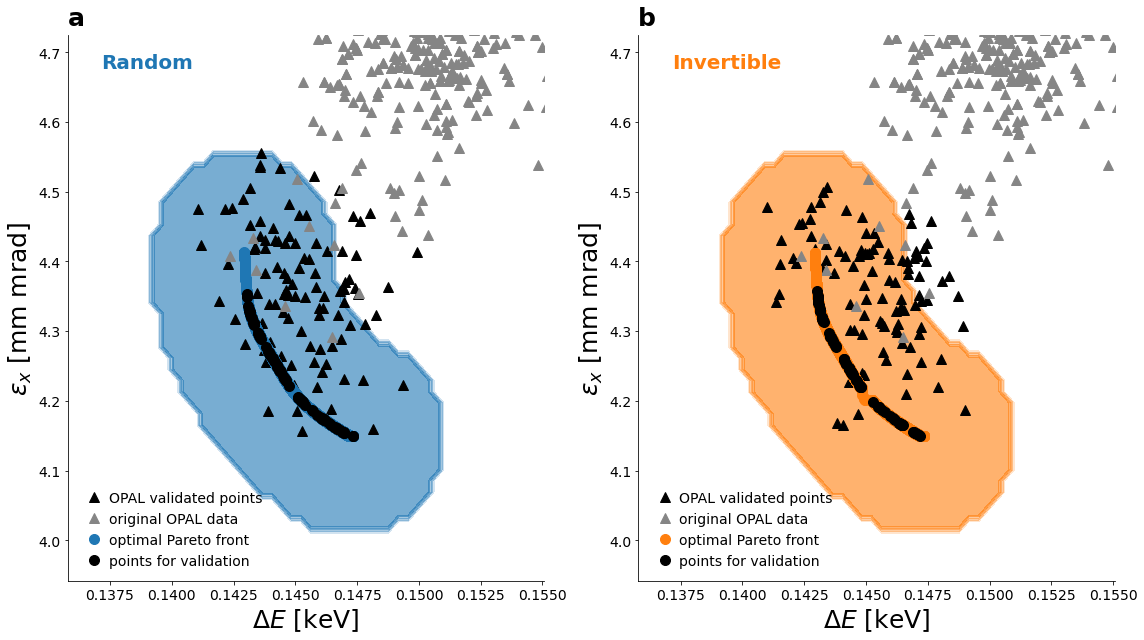

In [34]:
for qois in qois_list:
       
    if constr == True:
        combi = str(qois[0])+'__'+str(qois[1])+'_constr'
    else: 
        combi = str(qois[0])+'__'+str(qois[1])
   
    x_col =qois[0]
    y_col = qois[1]   
    if len(qois)==3:
        combi = combi+'__'+str(qois[2])
    elif len(qois)>3:
        combi = combi+'__len'+str(len(qois))
    data_dirs = []
    data_dirs.append(f'{base_dir}/forward_model/{combi}')
    data_dirs.append(f'{base_dir}/invertible_model2/{combi}')
    generations = [int(d.split('_')[1].split('.')[0]) for d in os.listdir(data_dirs[1])]
    generations = sorted(generations)
    current_plot_dir = f'{plot_dir}/objectives_per_gen/{combi}'

    if not os.path.exists(current_plot_dir):
        os.makedirs(current_plot_dir)
        
    all_dvars, all_objectives, limits,limits1, modellabel = load_data(data_dirs)
    
    generation_list_fw = all_objectives[0]["generation"].unique()
    generation_list_iv = all_objectives[1]["generation"].unique()

    dist_gd_all_fw,  dist_hv_all_fw,dist_gd_all_iv, dist_hv_all_iv=compute_pymoo_dist(all_objectives, generation_list_fw, generation_list_iv,x_col,y_col)


    
    modellabel = ['random','invertible']
    all_counts = []
    for dvars in all_dvars:
        counts = {}
        for g, df in dvars.groupby('generation'):
            counts[g] = df.shape[0]
        all_counts.append(counts)
    all_dvars_plot_fw = all_dvars[0][all_dvars[0]['generation']==999]
    all_dvars_plot_fw = all_dvars_plot_fw.drop(columns="generation")
    qoi_pred = surr.predict(all_dvars_plot_fw)
    qoi_pred =pd.DataFrame(data=qoi_pred, columns=qoi_columns)
    qoi_pred = qoi_pred.rename(dict_qoi,axis=1)
    qoi_pred['particle_losses'] = N_part_in - qoi_pred['Number of Macro Particles']
    qoi_pred = qoi_pred.drop(columns='Number of Macro Particles')
    qoi_pred['particle_losses'] = qoi_pred['particle_losses']/ N_part_in * 100.
    qoi_pred['emit_x']=qoi_pred['emit_x']*1e7
    all_dvars_plot_iv = all_dvars[1][all_dvars[1]['generation']==999]
    all_dvars_plot_iv = all_dvars_plot_iv.drop(columns="generation")
    qoi_pred_iv = surr.predict(all_dvars_plot_iv)
    qoi_pred_iv =pd.DataFrame(data=qoi_pred_iv, columns=qoi_columns)
    qoi_pred_iv = qoi_pred_iv.rename(dict_qoi,axis=1)
    qoi_pred_iv['particle_losses'] = N_part_in - qoi_pred_iv['Number of Macro Particles']
    qoi_pred_iv = qoi_pred_iv.drop(columns='Number of Macro Particles')
    qoi_pred_iv['particle_losses'] = qoi_pred_iv['particle_losses']/ N_part_in * 100.
    qoi_pred_iv['emit_x']=qoi_pred_iv['emit_x']*1e7

    
    gen_overview1 = all_objectives[0]['generation'].unique()
    gen_overview1 = gen_overview1[1:]
 #   gen_overview1 = [2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,  14,15,  16,  17,  18,  19,  20]
    all_volume_samples = []
    all_volume_means = []
    all_volume_stds = []
    for i, objectives in enumerate(all_objectives): 
        volume_samples = []
        volume_means = []
        volume_stds = []
        for i, gen in enumerate(gen_overview1):
            df = objectives.query('`generation` == @gen')
            dfx = df[[x_col,y_col]].reset_index(drop=True)
            volumes = sample_volumes(dfx,prediction_uncertainty_params,100)        

            vol_mean = np.mean(volumes)
            vol_std = np.std(volumes)

            volume_samples.append(volumes)
            volume_means.append(vol_mean)
            volume_stds.append(vol_std)

        volume_means = np.array(volume_means)
        volume_stds = np.array(volume_stds)

        all_volume_samples.append(volume_samples)
        all_volume_means.append(volume_means)
        all_volume_stds.append(volume_stds)

    

  #  plot_optimization_isodar(x_col,y_col,labels,all_objectives,gen_overview1,all_volume_means,all_volume_stds)    
  #  plot_nr_sol_hypervol(all_counts,modellabel,combi,plot_dir,dpi,dist_gd_all_fw,dist_hv_all_fw,dist_gd_all_iv,dist_hv_all_iv,generation_list_fw,generation_list_iv,endpoint)

#    plot_obj_conf_orig(gen_overview,all_objectives,x_col,y_col,modellabel,residual_quantiles,limits1,q,colormaps,objective_labels,current_plot_dir, data_qoi, combi)

   
    plot_opal_validation_fw_iv(limits1, x_col, y_col,qoi100opal, qoi100opal_iv,data_qoi,qoi_pred, qoi_pred_iv,qoi100toopal,qoi100toopal_iv,q,residual_quantiles,colormaps,objective_labels)


In [ ]:
 #   plot_nr_sol_hypervol(all_counts,modellabel,combi,plot_dir,dpi,dist_gd_all_fw,dist_hv_all_fw,dist_gd_all_iv,dist_hv_all_iv,generation_list_fw,generation_list_iv,endpoint)


In [ ]:
plot_opal_validation_fw_iv(limits1, x_col, y_col,qoi100opal, qoi100opal_iv,data_qoi,qoi_pred, qoi_pred_iv,qoi100toopal,qoi100toopal_iv,q,residual_quantiles,colormaps,objective_labels)


In [35]:
gen_overview1 = all_objectives[0]['generation'].unique()
gen_overview1 = gen_overview1[1:]

In [ ]:
def plot_all_together(x_col,y_col,labels,all_objectives,gen_overview1,all_volume_means,all_volume_stds,all_counts,modellabel,combi,plot_dir,dpi,dist_gd_all_fw,dist_hv_all_fw,dist_gd_all_iv,dist_hv_all_iv,generation_list_fw,generation_list_iv,endpoint,gen_overview,residual_quantiles,limits1,q,colormaps,objective_labels, data_qoi):

    gen_overview = [1,2,3,4,5,6,7,10,20,40,60,100,250,500,999]
        

    x_limits = [limits1[x_col][0]*0.995,limits1[x_col][1]]
    y_limits = limits1[y_col]
    fig, axes = plt.subplots(5, 4, figsize=(20, 20))
    
    configs_folder='/data/user/boiger_r/invertible_network_paper_results5000/models_30_11_2020/isodar/optimisation_paper_7/invertible_model2/configs'
    obj_config = pd.read_hdf(f'{configs_folder}/configs_dE__emit_x.hdf5', key='obj')
    poslist = [0,1,2,4,5,6,8,9,10,12,13,14,16,17,18]
    for i, gen in enumerate(gen_overview):  
        
        ax = axes.flatten()[poslist[i]]
#        ax.plot(data_qoi[x_col],data_qoi[y_col],'.',markersize = 10,color = sns.color_palette()[8], label = 'original data')
        ax.plot(obj_config[x_col],obj_config[y_col]*1e7,'ok',markerfacecolor='none',markersize = 10,label = 'initial')

        for i, objectives in enumerate(all_objectives):
            df = objectives.query('`generation` == @gen')
                
            ax.plot(df[x_col],
                    df[y_col],
                    'o',
                    markersize=10.,
                    color=sns.color_palette()[i],
                    label = modellabel[i])
            draw_confidence_intervals(df[x_col].values,
                                      df[y_col].values,
                                      [q],
                                      [residual_quantiles.loc[q, x_col]],
                                      [residual_quantiles.loc[q, y_col]],
                                      x_limits,
                                      y_limits,
                                      50,
                                      colormaps[i],
                                      ax)
            

        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)


        ax.set_xlabel(objective_labels[x_col], fontsize=axis_label_size)
        ax.set_ylabel(objective_labels[y_col], fontsize=axis_label_size)
        ax.tick_params(labelsize=axis_tick_size)

        ax.set_xlim(x_limits)
        ax.set_ylim(y_limits)

        ax.text(x=x_limits[0]*1.005,
                y=y_limits[1]*0.994,
                s=f'Generation {gen}',
                fontsize=annotation_size)
        if gen == 1:
            
            ax.legend(bbox_to_anchor=(-0.05, 0),loc='lower left', frameon= False, fontsize=axis_tick_size,handletextpad=0.00001)
       
    
    markersize = 7

    ax = axes.flatten()[3]
    for i, counts in enumerate(all_counts):
        ax.plot(counts.keys(), counts.values(), '-o', color=sns.color_palette()[i],markersize = markersize)

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    ax.text(x=80,
            y=5000,
            s='Random',
            color=sns.color_palette()[0],
            fontsize=annotation_size,
            fontweight= 'bold')
    ax.text(x=10,
            y=4300,
            s='Invertible',
            color=sns.color_palette()[1],
            fontsize=annotation_size,
            fontweight= 'bold')

    ax.set_xlabel('Generation', fontsize=axis_label_size)
    ax.set_ylabel('No. solutions', fontsize=axis_label_size)
    ax.tick_params(labelsize=axis_tick_size)

    
    
    ax = axes.flatten()[19]

    ax.plot(generation_list_fw, dist_gd_all_fw,'-*',color=sns.color_palette()[0], label = 'GD random',markersize = markersize)
    ax.plot(generation_list_iv, dist_gd_all_iv,'-*',color=sns.color_palette()[1], label = 'GD invertible',markersize = markersize)

    ax.plot(generation_list_fw,dist_hv_all_fw[-1]-dist_hv_all_fw,'-o',color=sns.color_palette()[0], label = 'HV diff random',markersize = markersize)
    ax.plot(generation_list_iv,dist_hv_all_fw[-1]-dist_hv_all_iv,'-o',color=sns.color_palette()[1],label = 'HV diff invertible',markersize = markersize)

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_xlabel('Generation', fontsize=axis_label_size )
    ax.set_ylabel('Conv. Metrics', fontsize=axis_label_size)
    ax.tick_params(labelsize=axis_tick_size)
    ax.legend(loc='upper right', frameon=False, fontsize=axis_tick_size)
    ax.set_xlim([0,endpoint])

   
   # offset = 10
    poslist = [7,11]
    for i, col in enumerate([x_col,y_col]):
        ax = axes.flatten()[poslist[i]]
        print(col)
        for i, label in enumerate(labels):
            values = all_objectives[i]
            minimum = values.groupby('generation').min()[col]
            maximum = values.groupby('generation').max()[col]

            ax.fill_between(x=minimum.index,
                            y1=minimum.values,
                            y2=maximum.values,
                            color=sns.color_palette()[i],
                            alpha=0.3)

      #  ax.set_ylim(limits[col])
        ax.set_xlim([0,100])
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)

        ax.set_xlabel('Generation', fontsize=axis_label_size)
        ax.set_ylabel(objective_labels[col], fontsize=axis_label_size)
        ax.tick_params(labelsize=axis_tick_size)
  #  ax.text(x=48, y=4.5, s=labels[0], fontsize=annotation_size,fontweight='bold', color=sns.color_palette()[0])
  #  ax.text(x=40, y=4.545, s=labels[1], fontsize=annotation_size,fontweight='bold', color=sns.color_palette()[1])

    ax = axes.flatten()[15]
    ax.plot(gen_overview1, all_volume_means[0], color = sns.color_palette()[0],label = labels[0])
    ax.plot(gen_overview1, all_volume_means[1], color = sns.color_palette()[1],label = labels[1])
    ax.fill_between(gen_overview1, all_volume_means[0] - all_volume_stds[0], all_volume_means[0] + all_volume_stds[0], alpha=0.3)
    ax.fill_between(gen_overview1, all_volume_means[1] - all_volume_stds[1], all_volume_means[1] + all_volume_stds[1], alpha=0.3)

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    ax.set_xlabel('Generation', fontsize=axis_label_size)
    ax.set_ylabel('$V_{ch}$', fontsize=axis_label_size)
    ax.tick_params(labelsize=axis_tick_size)

    
    ax_inset = ax.inset_axes([450, 0.0005, 500, 0.0075], transform=ax.transData)

    endp = 25
    line_width = 2.5
    ax_inset.plot(gen_overview1[:endp],
                    all_volume_means[0][:endp],
                    linewidth=line_width, 
                    color = sns.color_palette()[0])

    ax_inset.plot(gen_overview1[:endp],
                    all_volume_means[1][:endp],
                    linewidth=line_width, 
                    color = sns.color_palette()[1])
    ax_inset.fill_between(gen_overview1[:endp],
                          all_volume_means[0][:endp] - all_volume_stds[0][:endp],
                          all_volume_means[0][:endp] + all_volume_stds[0][:endp], alpha=0.3)
    ax_inset.fill_between(gen_overview1[:endp],
                          all_volume_means[1][:endp] - all_volume_stds[1][:endp],
                          all_volume_means[1][:endp] + all_volume_stds[1][:endp], alpha=0.3)


    ax_inset.set_xlim([0, 50])
    ax_inset.set_ylim([0., 0.007])
    #ax_inset.set_xticklabels([])
    ax_inset.spines['top'].set_visible(False)
    ax_inset.spines['right'].set_visible(False)
    ax_inset.tick_params(axis='y', labelsize=10)
    ax_inset.tick_params(axis='x', labelsize=10)

    patch, connector_lines = ax.indicate_inset([0, 0, 50, 0.007], ax_inset)
    #connector_lines[1].set_visible(True)
    #connector_lines[2].set_visible(True)
    #connector_lines[0].set_visible(True)
    #connector_lines[3].set_visible(True)
    #connector_lines[3].xy1 = (1.2, 1.0)


        
  

 
  
    
   # for i, char in enumerate(['a', 'b',]):
   #     axes.flatten()[i].set_title(char,
    #                                loc='left',
     #                               fontdict={
      #                                  'fontsize': subplot_letter_size,
       #                                 'fontweight': 'bold',
        #                            },
         #                           pad=10)
   

    axes.flatten()[0].set_title('a',loc='left',fontdict={
                                        'fontsize': subplot_letter_size,
                                        'fontweight': 'bold'},pad=10)
    axes.flatten()[3].set_title('b',loc='left',fontdict={
                                        'fontsize': subplot_letter_size,
                                        'fontweight': 'bold'},pad=10)
    
    axes.flatten()[7].set_title('c',loc='left',fontdict={
                                        'fontsize': subplot_letter_size,
                                        'fontweight': 'bold'},pad=10)
    
    axes.flatten()[11].set_title('d',loc='left',fontdict={
                                        'fontsize': subplot_letter_size,
                                        'fontweight': 'bold'},pad=10)

    axes.flatten()[15].set_title('e',loc='left',fontdict={
                                        'fontsize': subplot_letter_size,
                                        'fontweight': 'bold'},pad=10)

    axes.flatten()[19].set_title('f',loc='left',fontdict={
                                        'fontsize': subplot_letter_size,
                                        'fontweight': 'bold'},pad=10)

    fig.tight_layout()
    fig.align_labels()

    
    fig_title = 'optimization_all'+combi+'.jpg'
    fig.savefig(f'{plot_dir}/{fig_title}', dpi=dpi,bbox_inches='tight')


In [ ]:
plot_all_together(x_col,y_col,labels,all_objectives,gen_overview1,all_volume_means,all_volume_stds,all_counts,modellabel,combi,plot_dir,dpi,dist_gd_all_fw,dist_hv_all_fw,dist_gd_all_iv,dist_hv_all_iv,generation_list_fw,generation_list_iv,endpoint,gen_overview,residual_quantiles,limits1,q,colormaps,objective_labels, data_qoi)


In [78]:
def plot_all_together2(x_col,y_col,labels,all_objectives,gen_overview1,all_volume_means,all_volume_stds,all_counts,modellabel,combi,plot_dir,dpi,dist_gd_all_fw,dist_hv_all_fw,dist_gd_all_iv,dist_hv_all_iv,generation_list_fw,generation_list_iv,endpoint,gen_overview,residual_quantiles,limits1,q,colormaps,objective_labels, data_qoi,limits, qoi100opal, qoi100opal_iv,qoi_pred, qoi_pred_iv,qoi100toopal,qoi100toopal_iv):


    gen_overview = [1,2,3,5,10,20,40,100,999]
        

    x_limits = [limits1[x_col][0]*0.995,limits1[x_col][1]]
    y_limits = limits1[y_col]
    #fig, axes = plt.subplots(5, 4, figsize=(20, 20))
    fig = plt.figure(constrained_layout = True, figsize = (20,20))
    gs = fig.add_gridspec(nrows=10, ncols =8)
    
    configs_folder='/data/user/boiger_r/invertible_network_paper_results5000/models_30_11_2020/isodar/optimisation_paper_7/invertible_model2/configs'
    obj_config = pd.read_hdf(f'{configs_folder}/configs_dE__emit_x.hdf5', key='obj')
    #poslist = [0,1,2,4,5,6,8,9,10]
    gridlist = [fig.add_subplot(gs[0:2,-8:-6]),fig.add_subplot(gs[0:2,-6:-4]),fig.add_subplot(gs[0:2,-4:-2]),
                fig.add_subplot(gs[2:4, -8:-6]),fig.add_subplot(gs[2:4,-6:-4]),fig.add_subplot(gs[2:4,-4:-2]),
                fig.add_subplot(gs[4:6, -8:-6]),fig.add_subplot(gs[4:6, -6:-4]),fig.add_subplot(gs[4:6,-4:-2])]

    for j, gen in enumerate(gen_overview):  
        
        #ax = axes.flatten()[poslist[i]]
        f1 = gridlist[j]
#        ax.plot(data_qoi[x_col],data_qoi[y_col],'.',markersize = 10,color = sns.color_palette()[8], label = 'original data')
        f1.plot(obj_config[x_col],obj_config[y_col]*1e7,'ok',markerfacecolor='none',markersize = 10,label = 'initial')
        print(j)
        if j==0:
            f1.set_title('a',loc='left',fontdict={
                                        'fontsize': subplot_letter_size,
                                        'fontweight': 'bold'},pad=10)
        for i, objectives in enumerate(all_objectives):
            df = objectives.query('`generation` == @gen')
                
            f1.plot(df[x_col],
                    df[y_col],
                    'o',
                    markersize=10.,
                    color=sns.color_palette()[i],
                    label = modellabel[i])
            draw_confidence_intervals(df[x_col].values,
                                      df[y_col].values,
                                      [q],
                                      [residual_quantiles.loc[q, x_col]],
                                      [residual_quantiles.loc[q, y_col]],
                                      x_limits,
                                      y_limits,
                                      50,
                                      colormaps[i],
                                      f1)
            

        f1.spines['top'].set_visible(False)
        f1.spines['right'].set_visible(False)


        f1.set_xlabel(objective_labels[x_col], fontsize=axis_label_size)
        f1.set_ylabel(objective_labels[y_col], fontsize=axis_label_size)
        f1.tick_params(labelsize=axis_tick_size)

        f1.set_xlim(x_limits)
        f1.set_ylim(y_limits)

        f1.text(x=x_limits[0]*1.005,
                y=y_limits[1]*0.994,
                s=f'Generation {gen}',
                fontsize=annotation_size)
        if gen == 1:
            
            f1.legend(bbox_to_anchor=(-0.05, 0),loc='lower left', frameon= False, fontsize=axis_tick_size,handletextpad=0.00001)
       

    markersize = 7

    f2 = fig.add_subplot(gs[0:2, -2:])
    for i, counts in enumerate(all_counts):
        f2.plot(counts.keys(), counts.values(), '-o', color=sns.color_palette()[i],markersize = markersize)

    f2.spines['top'].set_visible(False)
    f2.spines['right'].set_visible(False)

    f2.text(x=80,
            y=5000,
            s='Random',
            color=sns.color_palette()[0],
            fontsize=annotation_size,
            fontweight= 'bold')
    f2.text(x=10,
            y=4300,
            s='Invertible',
            color=sns.color_palette()[1],
            fontsize=annotation_size,
            fontweight= 'bold')

    f2.set_xlabel('Generation', fontsize=axis_label_size)
    f2.set_ylabel('No. solutions', fontsize=axis_label_size)
    f2.tick_params(labelsize=axis_tick_size)

    f2.set_title('b',loc='left',fontdict={
                                        'fontsize': subplot_letter_size,
                                        'fontweight': 'bold'},pad=10)
    
    f3 = fig.add_subplot(gs[2:4, -2:])

    f3.plot(generation_list_fw, dist_gd_all_fw,'-*',color=sns.color_palette()[0], label = 'GD random',markersize = markersize)
    f3.plot(generation_list_iv, dist_gd_all_iv,'-*',color=sns.color_palette()[1], label = 'GD invertible',markersize = markersize)

    f3.plot(generation_list_fw,dist_hv_all_fw[-1]-dist_hv_all_fw,'-o',color=sns.color_palette()[0], label = 'HV diff random',markersize = markersize)
    f3.plot(generation_list_iv,dist_hv_all_fw[-1]-dist_hv_all_iv,'-o',color=sns.color_palette()[1],label = 'HV diff invertible',markersize = markersize)

    f3.spines['top'].set_visible(False)
    f3.spines['right'].set_visible(False)
    f3.set_xlabel('Generation', fontsize=axis_label_size )
    f3.set_ylabel('Conv. Metrics', fontsize=axis_label_size)
    f3.tick_params(labelsize=axis_tick_size)
    f3.legend(loc='upper right', frameon=False, fontsize=axis_tick_size)
    f3.set_xlim([0,endpoint])

    f3.set_title('c',loc='left',fontdict={
                                        'fontsize': subplot_letter_size,
                                        'fontweight': 'bold'},pad=10)
   # offset = 10
    poslist = [fig.add_subplot(gs[4:6, -2:]),fig.add_subplot(gs[6:8, -2:])]
    for i, col in enumerate([x_col,y_col]):
        #ax = axes.flatten()[poslist[i]]
        f4 = poslist[i]
        if i==0:
            f4.set_title('d',loc='left',fontdict={
                                        'fontsize': subplot_letter_size,
                                        'fontweight': 'bold'},pad=10)

        print(col)
        for i, label in enumerate(labels):
            values = all_objectives[i]
            minimum = values.groupby('generation').min()[col]
            maximum = values.groupby('generation').max()[col]

            f4.fill_between(x=minimum.index,
                            y1=minimum.values,
                            y2=maximum.values,
                            color=sns.color_palette()[i],
                            alpha=0.3)

      #  ax.set_ylim(limits[col])
        f4.set_xlim([0,100])
        f4.spines['top'].set_visible(False)
        f4.spines['right'].set_visible(False)

        f4.set_xlabel('Generation', fontsize=axis_label_size)
        f4.set_ylabel(objective_labels[col], fontsize=axis_label_size)
        f4.tick_params(labelsize=axis_tick_size)
  #  ax.text(x=48, y=4.5, s=labels[0], fontsize=annotation_size,fontweight='bold', color=sns.color_palette()[0])
  #  ax.text(x=40, y=4.545, s=labels[1], fontsize=annotation_size,fontweight='bold', color=sns.color_palette()[1])

    f5 =fig.add_subplot(gs[8:, -2:])
    f5.plot(gen_overview1, all_volume_means[0], color = sns.color_palette()[0],label = labels[0])
    f5.plot(gen_overview1, all_volume_means[1], color = sns.color_palette()[1],label = labels[1])
    f5.fill_between(gen_overview1, all_volume_means[0] - all_volume_stds[0], all_volume_means[0] + all_volume_stds[0], alpha=0.3)
    f5.fill_between(gen_overview1, all_volume_means[1] - all_volume_stds[1], all_volume_means[1] + all_volume_stds[1], alpha=0.3)

    f5.spines['top'].set_visible(False)
    f5.spines['right'].set_visible(False)

    f5.set_xlabel('Generation', fontsize=axis_label_size)
    f5.set_ylabel('$V_{ch}$', fontsize=axis_label_size)
    f5.tick_params(labelsize=axis_tick_size)

    
    f5_inset = f5.inset_axes([450, 0.0005, 500, 0.0075], transform=f5.transData)

    endp = 25
    line_width = 2.5
    f5_inset.plot(gen_overview1[:endp],
                    all_volume_means[0][:endp],
                    linewidth=line_width, 
                    color = sns.color_palette()[0])

    f5_inset.plot(gen_overview1[:endp],
                    all_volume_means[1][:endp],
                    linewidth=line_width, 
                    color = sns.color_palette()[1])
    f5_inset.fill_between(gen_overview1[:endp],
                          all_volume_means[0][:endp] - all_volume_stds[0][:endp],
                          all_volume_means[0][:endp] + all_volume_stds[0][:endp], alpha=0.3)
    f5_inset.fill_between(gen_overview1[:endp],
                          all_volume_means[1][:endp] - all_volume_stds[1][:endp],
                          all_volume_means[1][:endp] + all_volume_stds[1][:endp], alpha=0.3)


    f5_inset.set_xlim([0, 50])
    f5_inset.set_ylim([0., 0.007])
    #ax_inset.set_xticklabels([])
    f5_inset.spines['top'].set_visible(False)
    f5_inset.spines['right'].set_visible(False)
    f5_inset.tick_params(axis='y', labelsize=10)
    f5_inset.tick_params(axis='x', labelsize=10)

    patch, connector_lines = f5.indicate_inset([0, 0, 50, 0.007], f5_inset)
    
    f5.set_title('g',loc='left',fontdict={
                                        'fontsize': subplot_letter_size,
                                        'fontweight': 'bold'},pad=10)
    #connector_lines[1].set_visible(True)
    #connector_lines[2].set_visible(True)
    #connector_lines[0].set_visible(True)
    #connector_lines[3].set_visible(True)
    #connector_lines[3].xy1 = (1.2, 1.0)

    markersize = 10
    f6 = fig.add_subplot(gs[6:10, :-5])

    x_limits = limits[x_col]
    y_limits = limits[y_col]

    f6.plot(qoi100opal[x_col],qoi100opal[y_col],'^k', markersize = markersize, label ='OPAL validated points')
    #plt.plot(qoi5opal['dE'],qoi5opal['emit_x'],'+g')
    #plt.plot(qoi5toopal['dE'],qoi5toopal['emit_x'],'+m')
    f6.plot(data_qoi[x_col],data_qoi[y_col],'^', markersize = markersize, color ='#858585', label = 'original OPAL data')
    f6.plot(qoi_pred[x_col],qoi_pred[y_col],'o', markersize =markersize, color = sns.color_palette()[0], label = 'optimal Pareto front')
    f6.plot(qoi100toopal[x_col],qoi100toopal[y_col],'ok', markersize =markersize, label = 'points for validation')

    draw_confidence_intervals(qoi_pred[x_col].values,
                          qoi_pred[y_col].values,
                          [q],
                          [residual_quantiles.loc[q, x_col]],
                          [residual_quantiles.loc[q, y_col]],
                          x_limits,
                          y_limits,
                          50,
                          colormaps[0],
                          f6)

    f6.spines['top'].set_visible(False)
    f6.spines['right'].set_visible(False)
    f6.set_xlabel(objective_labels[x_col],fontsize=axis_label_size)
    f6.set_ylabel(objective_labels[y_col], fontsize=axis_label_size)
    f6.tick_params(labelsize=axis_tick_size)
    f6.set_xlim(x_limits)
    f6.set_ylim(y_limits)
    fig.align_labels()
    f6.legend(loc='lower left', frameon=False, fontsize=axis_tick_size,handletextpad=0.01)
    f6.text(x=x_limits[0]*1.01,
            y=y_limits[1]*0.99,
            s='Random',
            color=sns.color_palette()[0],
            fontsize=annotation_size, 
            fontweight = 'bold')
    
    f6.set_title('e',loc='left',fontdict={
                                        'fontsize': subplot_letter_size,
                                        'fontweight': 'bold'},pad=10)
    f7 = fig.add_subplot(gs[6:10,-5:-2])
    x_limits = limits[x_col]
    y_limits = limits[y_col]
    #plasma = cm.get_cmap('plasma', 12)


    f7.plot(qoi100opal_iv[x_col],qoi100opal_iv[y_col],'^k', markersize = markersize, label ='OPAL validated points')
    #plt.plot(qoi5opal['dE'],qoi5opal['emit_x'],'+g')
    #plt.plot(qoi5toopal['dE'],qoi5toopal['emit_x'],'+m')
    f7.plot(data_qoi[x_col],data_qoi[y_col],'^',  color ='#858585',markersize = markersize, label = 'original OPAL data')
    f7.plot(qoi_pred_iv[x_col],qoi_pred_iv[y_col],'o', markersize =markersize, color = sns.color_palette()[1], label = 'optimal Pareto front')
    f7.plot(qoi100toopal_iv[x_col],qoi100toopal_iv[y_col],'ok', markersize =markersize, label = 'points for validation')

    draw_confidence_intervals(qoi_pred[x_col].values,
                          qoi_pred[y_col].values,
                          [q],
                          [residual_quantiles.loc[q, x_col]],
                          [residual_quantiles.loc[q, y_col]],
                          x_limits,
                          y_limits,
                          50,
                          colormaps[1],
                          f7)

    f7.spines['top'].set_visible(False)
    f7.spines['right'].set_visible(False)
    f7.set_xlabel(objective_labels[x_col], fontsize=axis_label_size)
    f7.set_ylabel(objective_labels[y_col], fontsize=axis_label_size)
    f7.tick_params(labelsize=axis_tick_size)
    f7.set_xlim(x_limits)
    f7.set_ylim(y_limits)
    fig.align_labels()
    f7.legend(loc='lower left', frameon=False, fontsize=axis_tick_size,handletextpad=0.01)
    f7.text(x=x_limits[0]*1.01,
            y=y_limits[1]*0.99,
            s='Invertible',
            color=sns.color_palette()[1],
            fontsize=annotation_size, 
            fontweight = 'bold')
    

    f7.set_title('f',loc='left',fontdict={
                                        'fontsize': subplot_letter_size,
                                        'fontweight': 'bold'},pad=10)    
  

    
    fig.tight_layout()
    fig.align_labels()

    
    fig_title = 'optimization_all'+combi+'.jpg'
    fig.savefig(f'{plot_dir}/{fig_title}', dpi=dpi,bbox_inches='tight')    
    
    
   # for i, char in enumerate(['a', 'b',]):
   #     axes.flatten()[i].set_title(char,
    #                                loc='left',
     #                               fontdict={
      #                                  'fontsize': subplot_letter_size,
       #                                 'fontweight': 'bold',
        #                            },
         #                           pad=10)
   


'''
    
    
    axes.flatten()[7].set_title('c',loc='left',fontdict={
                                        'fontsize': subplot_letter_size,
                                        'fontweight': 'bold'},pad=10)
    
    axes.flatten()[11].set_title('d',loc='left',fontdict={
                                        'fontsize': subplot_letter_size,
                                        'fontweight': 'bold'},pad=10)

    axes.flatten()[15].set_title('e',loc='left',fontdict={
                                        'fontsize': subplot_letter_size,
                                        'fontweight': 'bold'},pad=10)

    axes.flatten()[19].set_title('f',loc='left',fontdict={
                                        'fontsize': subplot_letter_size,
                                        'fontweight': 'bold'},pad=10)
'''



"\n    \n    \n    axes.flatten()[7].set_title('c',loc='left',fontdict={\n                                        'fontsize': subplot_letter_size,\n                                        'fontweight': 'bold'},pad=10)\n    \n    axes.flatten()[11].set_title('d',loc='left',fontdict={\n                                        'fontsize': subplot_letter_size,\n                                        'fontweight': 'bold'},pad=10)\n\n    axes.flatten()[15].set_title('e',loc='left',fontdict={\n                                        'fontsize': subplot_letter_size,\n                                        'fontweight': 'bold'},pad=10)\n\n    axes.flatten()[19].set_title('f',loc='left',fontdict={\n                                        'fontsize': subplot_letter_size,\n                                        'fontweight': 'bold'},pad=10)\n"

0
1
2
3
4
5
6
7
8
dE
emit_x


/data/user/boiger_r/invertible_neural_net/lib/python3.7/site-packages/ipykernel_launcher.py:298: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.


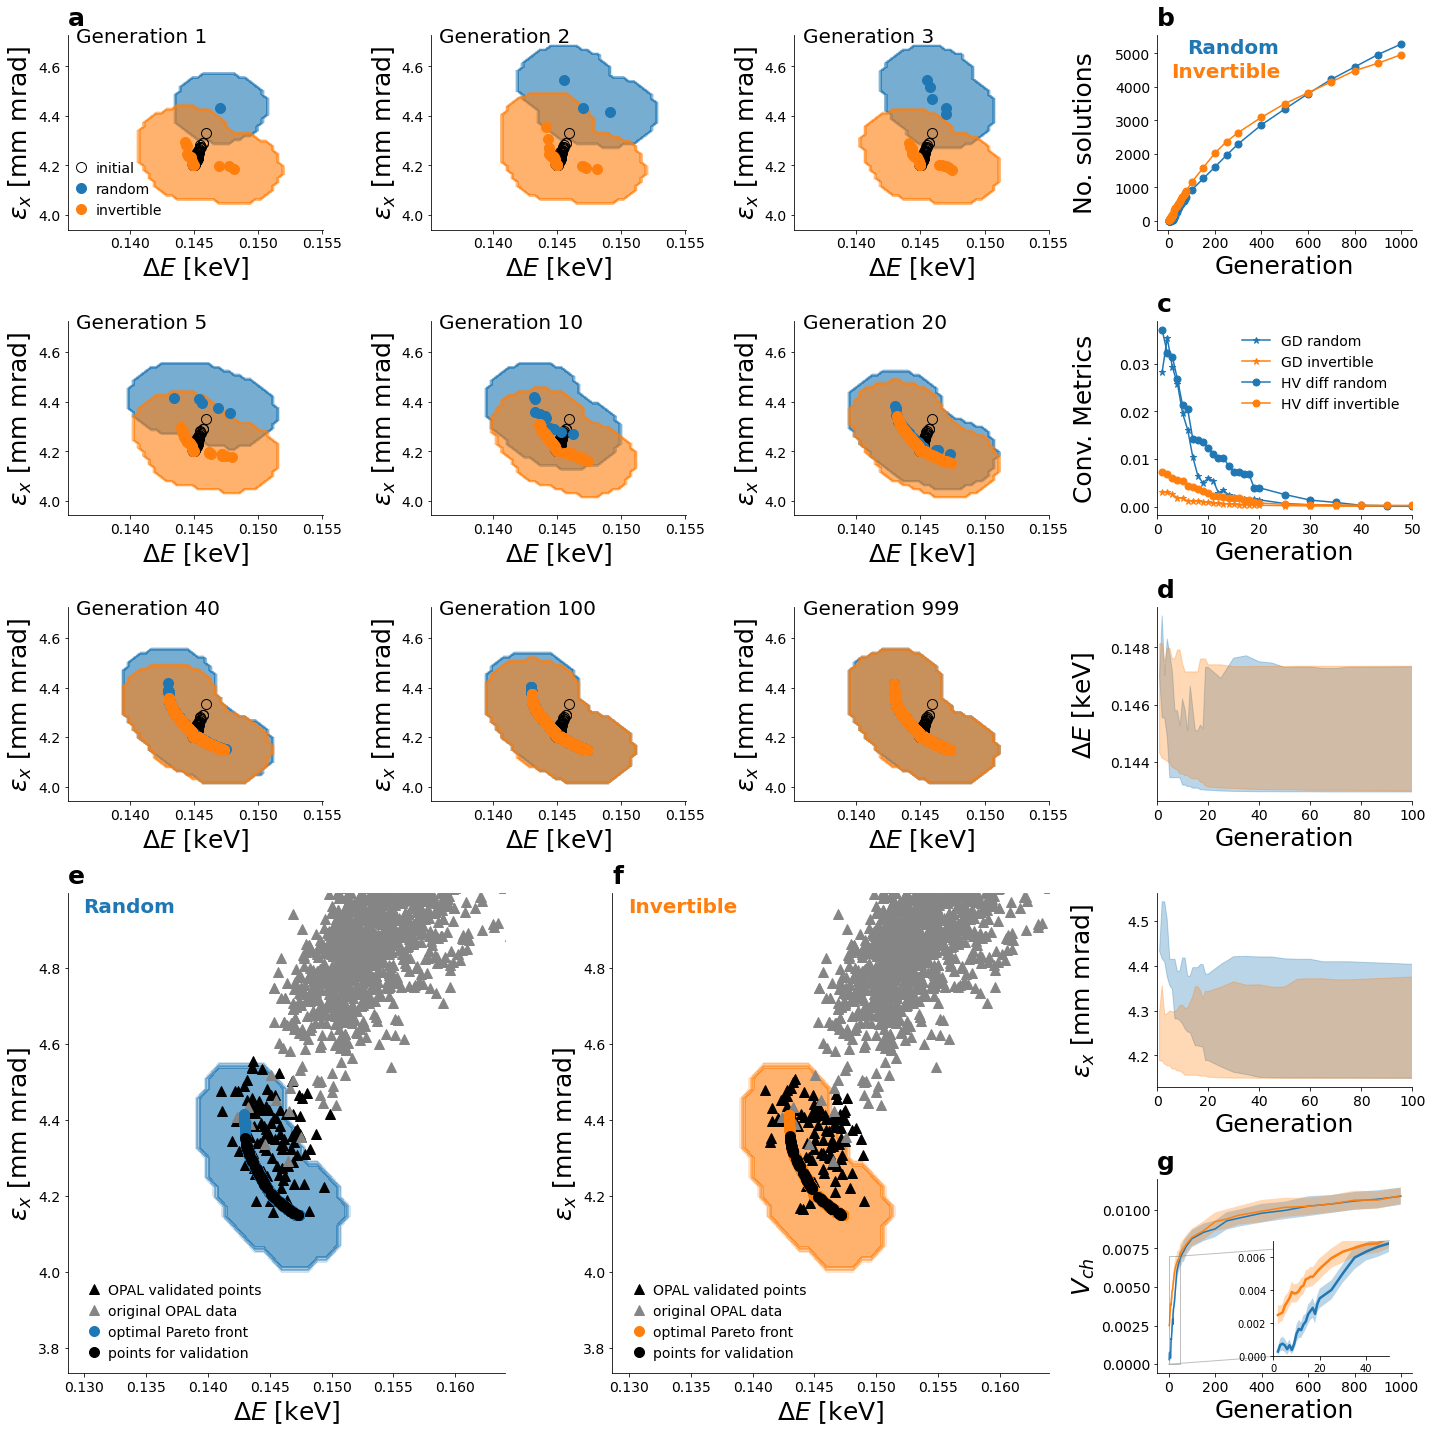

In [79]:
plot_all_together2(x_col,y_col,labels,all_objectives,gen_overview1,all_volume_means,all_volume_stds,all_counts,modellabel,combi,plot_dir,dpi,dist_gd_all_fw,dist_hv_all_fw,dist_gd_all_iv,dist_hv_all_iv,generation_list_fw,generation_list_iv,endpoint,gen_overview,residual_quantiles,limits1,q,colormaps,objective_labels, data_qoi,limits, qoi100opal, qoi100opal_iv,qoi_pred, qoi_pred_iv,qoi100toopal,qoi100toopal_iv)

In [ ]:
len(gen_overview1)

In [ ]:
len(all_volume_means[0])